# Model Comparison
### Author: Terence Kaplan

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read the CSV file into a data frame
df_sel_var = pd.read_csv('./df_sel_var.csv')
pd.set_option('display.max_columns', None)
df_sel_var.head()

,Is Laundering,Day,From Account Average Amount Paid in ACH,To Account Average Amount Received in ACH,Amount Paid,From Account Average Amount Paid in Cheque,To Account Average Amount Received in Cheque,To Account Received Transaction Count,To Account Paid Transaction Count,From Account Average Amount Received,To Account Amount Received Median,From Account Received Transaction Count,From Account Paid Transaction Count,From Account Amount Paid Max,From Account Average Amount Paid in Credit Card,From Account Amount Paid Sum,From Account Amount Paid Median,From Account Std Dev Amount Paid,From Account Average Amount Paid in Reinvestment,To Account Std Dev Amount Received,From Account Amount Paid Mean
0,0,1,2058.070954,0.000000,12.677957,0.000000,2.543906e+03,14.0,3.0,3998.701632,12.677957,14.0,3.0,12.677957,0.000000,12.677957,12.677957,1.127012e+03,113.920650,7731.948289,12.677957
1,0,1,2089.542390,0.000000,2977.670116,0.000000,0.000000e+00,2.0,3.0,1493.562942,2977.670116,2.0,3.0,2977.670116,0.000000,2977.670116,2977.670116,1.523473e+03,1493.562942,2098.844493,2977.670116
2,0,1,0.000000,156.286217,74.103124,0.000000,5.899356e+04,41.0,57.0,2089.542390,74.103124,1.0,10.0,74.103124,63.796792,74.103124,74.103124,8.532493e+01,0.000000,69680.093067,74.103124
3,0,1,0.000000,0.000000,13886.360391,0.000000,1.370731e+06,4.0,9.0,0.000000,13886.360391,0.0,1.0,13886.360391,0.000000,13886.360391,13886.360391,1.386710e+06,0.000000,682237.153093,13886.360391
4,0,1,0.000000,0.000000,10.330801,273.557031,1.767892e+02,4.0,30.0,220.575561,10.330801,4.0,30.0,10.330801,0.368601,10.330801,10.330801,7.612480e+02,264.361920,213.488954,10.330801


In [3]:
# Inspect the data set
df_sel_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5006175 entries, 0 to 5006174
Data columns (total 21 columns):
 #   Column                                            Dtype  
---  ------                                            -----  
 0   Is Laundering                                     int64  
 1   Day                                               int64  
 2   From Account Average Amount Paid in ACH           float64
 3   To Account Average Amount Received in ACH         float64
 4   Amount Paid                                       float64
 5   From Account Average Amount Paid in Cheque        float64
 6   To Account Average Amount Received in Cheque      float64
 7   To Account Received Transaction Count             float64
 8   To Account Paid Transaction Count                 float64
 9   From Account Average Amount Received              float64
 10  To Account Amount Received Median                 float64
 11  From Account Received Transaction Count           float64
 12  

### Correlation Matrix

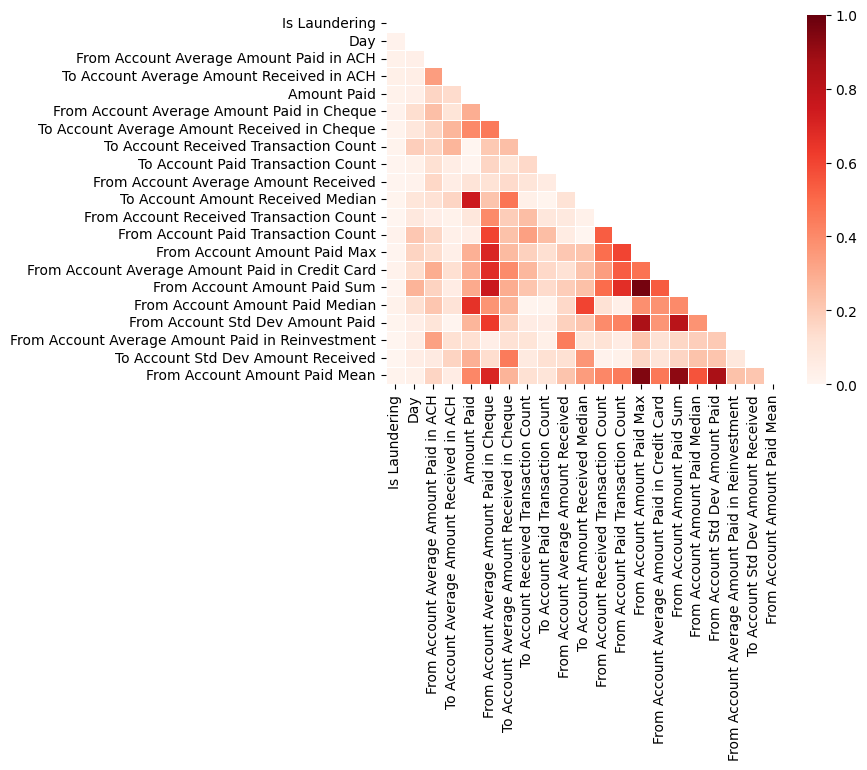

In [4]:
# Compute the correlation matrix with absolute values
corr_matrix = df_sel_var.corr(method='spearman')
abs_corr_matrix = abs(corr_matrix)

# Generate a mask to hide upper triangle
mask = np.triu(np.ones_like(abs_corr_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(abs_corr_matrix, cmap='Reds', mask=mask, vmin=0, vmax=1, linewidths=.5)
plt.show()

In [5]:
# Show all variable pairs with a correlation higher than 0.9

# Fill diagonal with zeros to avoid self-correlation
np.fill_diagonal(abs_corr_matrix.values, 0)

# Convert matrix to data frame containing all combination of two variables and their correlation
abs_corr_matrix_df = abs_corr_matrix.stack().reset_index()

# Name columns 
abs_corr_matrix_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Filter all variable pairs with a correlation higher than 0.9
high_abs_corr_matrix_df = abs_corr_matrix_df[abs_corr_matrix_df['Correlation'].abs() > 0.9]

high_abs_corr_matrix_df

,Variable 1,Variable 2,Correlation
288,From Account Amount Paid Max,From Account Amount Paid Sum,0.969288
293,From Account Amount Paid Max,From Account Amount Paid Mean,0.946133
328,From Account Amount Paid Sum,From Account Amount Paid Max,0.969288
335,From Account Amount Paid Sum,From Account Amount Paid Mean,0.921410
433,From Account Amount Paid Mean,From Account Amount Paid Max,0.946133
435,From Account Amount Paid Mean,From Account Amount Paid Sum,0.921410


In [6]:
# Drop variables to avoid correlation of over 0.9
df_sel_var = df_sel_var.drop(columns=["From Account Amount Paid Mean", "From Account Amount Paid Max"])

### Median and Mean Comparison

In [7]:
# Median comparison rounded to two decimal places
df_sel_var.groupby('Is Laundering').median().round(2)

,Day,From Account Average Amount Paid in ACH,To Account Average Amount Received in ACH,Amount Paid,From Account Average Amount Paid in Cheque,To Account Average Amount Received in Cheque,To Account Received Transaction Count,To Account Paid Transaction Count,From Account Average Amount Received,To Account Amount Received Median,From Account Received Transaction Count,From Account Paid Transaction Count,From Account Average Amount Paid in Credit Card,From Account Amount Paid Sum,From Account Amount Paid Median,From Account Std Dev Amount Paid,From Account Average Amount Paid in Reinvestment,To Account Std Dev Amount Received
Is Laundering,,,,,,,,,,,,,,,,,,
0,5.0,28.18,0.00,856.70,3891.11,2092.18,25.0,3.0,5906.11,1035.29,21.0,41.0,1373.33,180514.78,1092.04,24486.68,1098.80,14635.77
1,7.0,6291.57,6432.13,5668.88,0.00,538.24,19.0,4.0,7709.37,2178.68,19.0,16.0,0.00,202124.80,3507.51,45412.90,707.55,7736.35


In [8]:
# Mean comparison rounded to two decimal places
df_sel_var.groupby('Is Laundering').mean().round(2)

,Day,From Account Average Amount Paid in ACH,To Account Average Amount Received in ACH,Amount Paid,From Account Average Amount Paid in Cheque,To Account Average Amount Received in Cheque,To Account Received Transaction Count,To Account Paid Transaction Count,From Account Average Amount Received,To Account Amount Received Median,From Account Received Transaction Count,From Account Paid Transaction Count,From Account Average Amount Paid in Credit Card,From Account Amount Paid Sum,From Account Amount Paid Median,From Account Std Dev Amount Paid,From Account Average Amount Paid in Reinvestment,To Account Std Dev Amount Received
Is Laundering,,,,,,,,,,,,,,,,,,
0,4.84,514888.99,398110.51,318548.07,394312.0,395492.14,26.77,70.06,1292406.35,153083.56,70.38,8371.44,3534.08,1.521328e+09,130109.21,1378258.07,226762.87,803714.04
1,6.66,5076444.22,1178197.33,5111050.77,883633.5,215477.51,21.03,18.93,639096.65,141893.83,91.23,11741.02,1837.49,2.101922e+09,4422242.71,3045124.90,563904.07,1774280.98


In [9]:
# Perform t-Tests for all independent variables

# Split the data into legitimate and fraudulent cases
legitimate = df_sel_var[df_sel_var['Is Laundering'] == 0]
fraudulent = df_sel_var[df_sel_var['Is Laundering'] == 1]

# Check variances
np.var(legitimate), np.var(fraudulent)

# Create empty list to collect results
results = []

# Loop over all variables and perform Welch's t-test
for column in df_sel_var.columns:
    if column != 'Is Laundering':
        t_stat, p_val = ttest_ind(legitimate[column], fraudulent[column], equal_var=False)
        results.append({'Variable': column, 't-Statistic': t_stat, 'p-Value': p_val})

# Create data frame and round to two decimal places
results_df = pd.DataFrame(results)
results_df.round(2)

,Variable,t-Statistic,p-Value
0,Day,-38.06,0.00
1,From Account Average Amount Paid in ACH,-1.42,0.16
2,To Account Average Amount Received in ACH,-2.49,0.01
3,Amount Paid,-1.49,0.14
4,From Account Average Amount Paid in Cheque,-1.47,0.14
5,To Account Average Amount Received in Cheque,3.58,0.00
6,To Account Received Transaction Count,25.69,0.00
7,To Account Paid Transaction Count,39.15,0.00
8,From Account Average Amount Received,7.16,0.00
9,To Account Amount Received Median,0.22,0.83


### Divide Data Set into Features and Labels & Train-Test-Split

In [10]:
# Set random state used for all models
random_state = 10

In [11]:
# Create features X and labels y
def split_dataset(dataset):
    X = dataset.drop("Is Laundering", axis=1)
    y = dataset["Is Laundering"].values
    return X, y

X, y = split_dataset(df_sel_var)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state, stratify=y)

### Resampling

In [12]:
# First, oversampling of minority class to 1% of majority class
# ros = RandomOverSampler(sampling_strategy=0.01, random_state=random_state)
# X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

# Then, undersampling of majority class to 100x the minority class
rus = RandomUnderSampler(sampling_strategy=0.01, random_state=random_state)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

### Logarithmize and Standardize the Variables

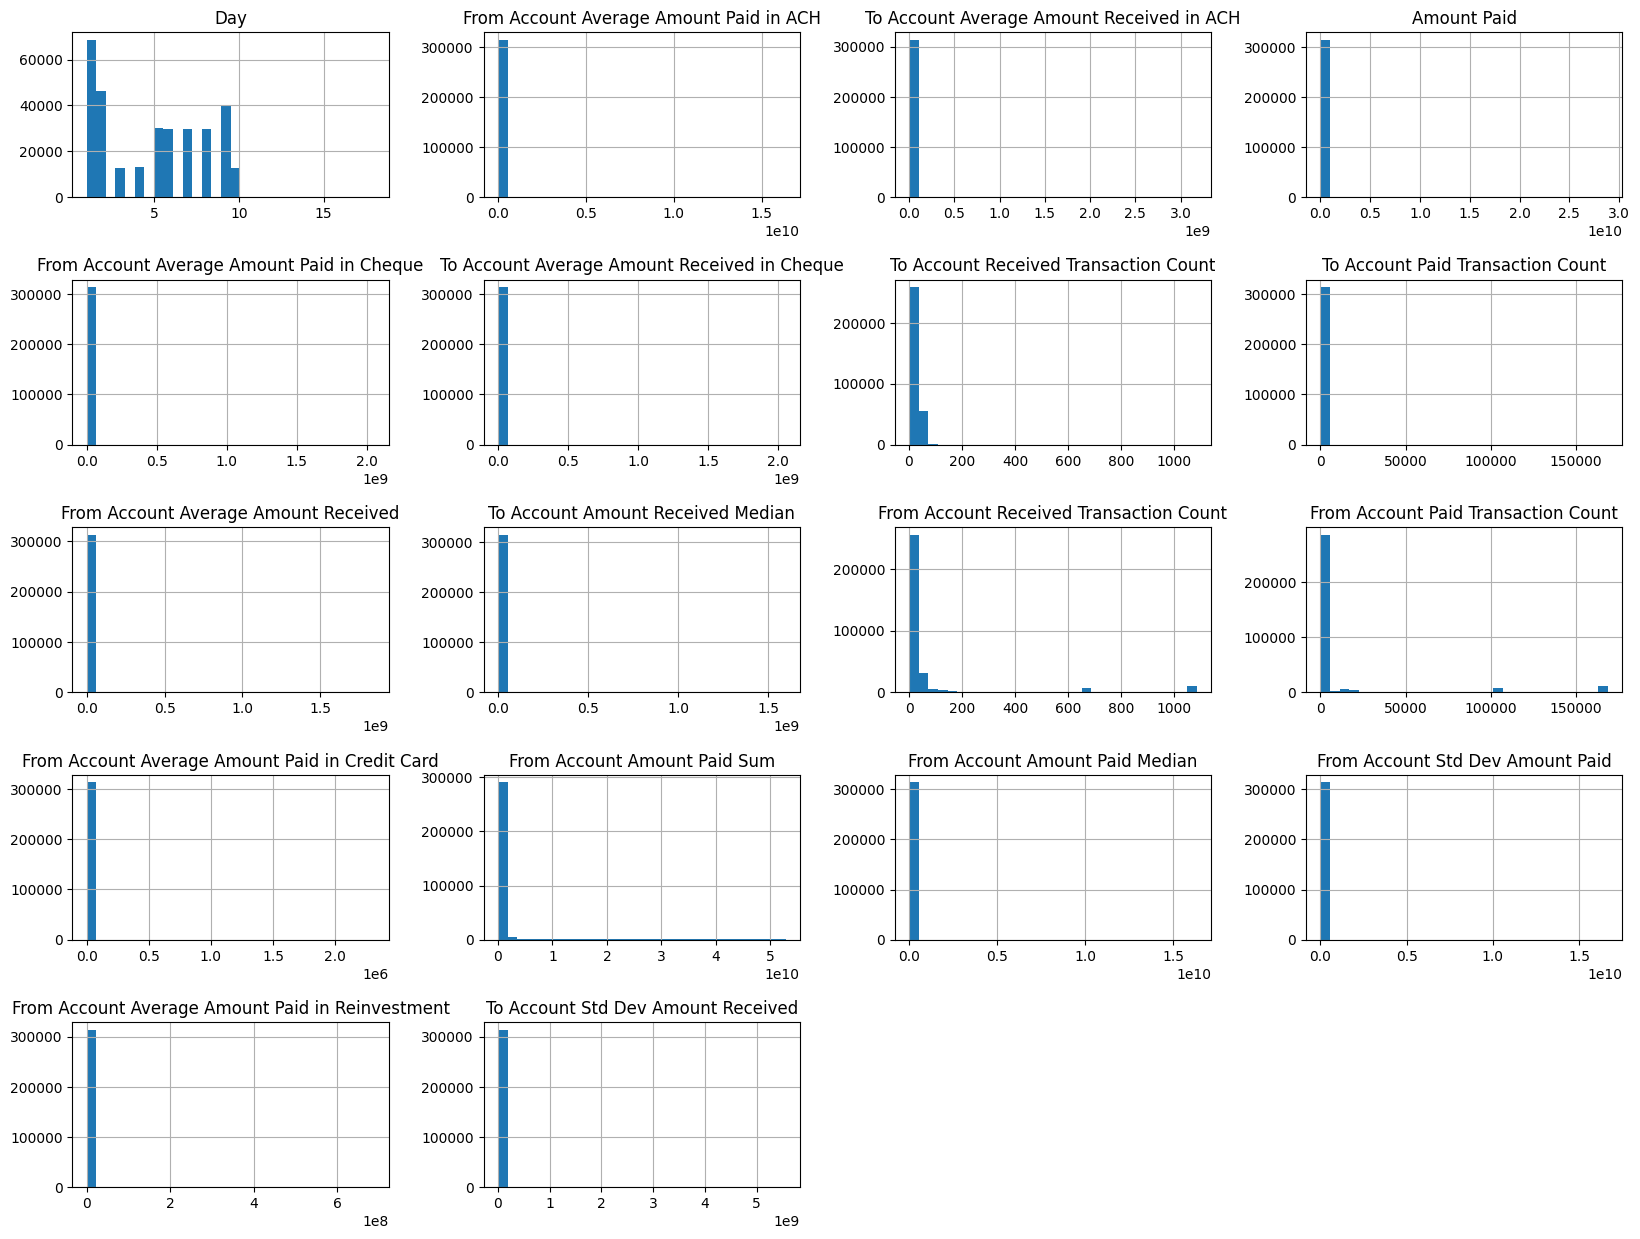

In [13]:
# Show histograms of all variables before transformation
X_resampled.hist(bins=30, figsize=(20,15))
plt.subplots_adjust(hspace=0.5)
plt.show()

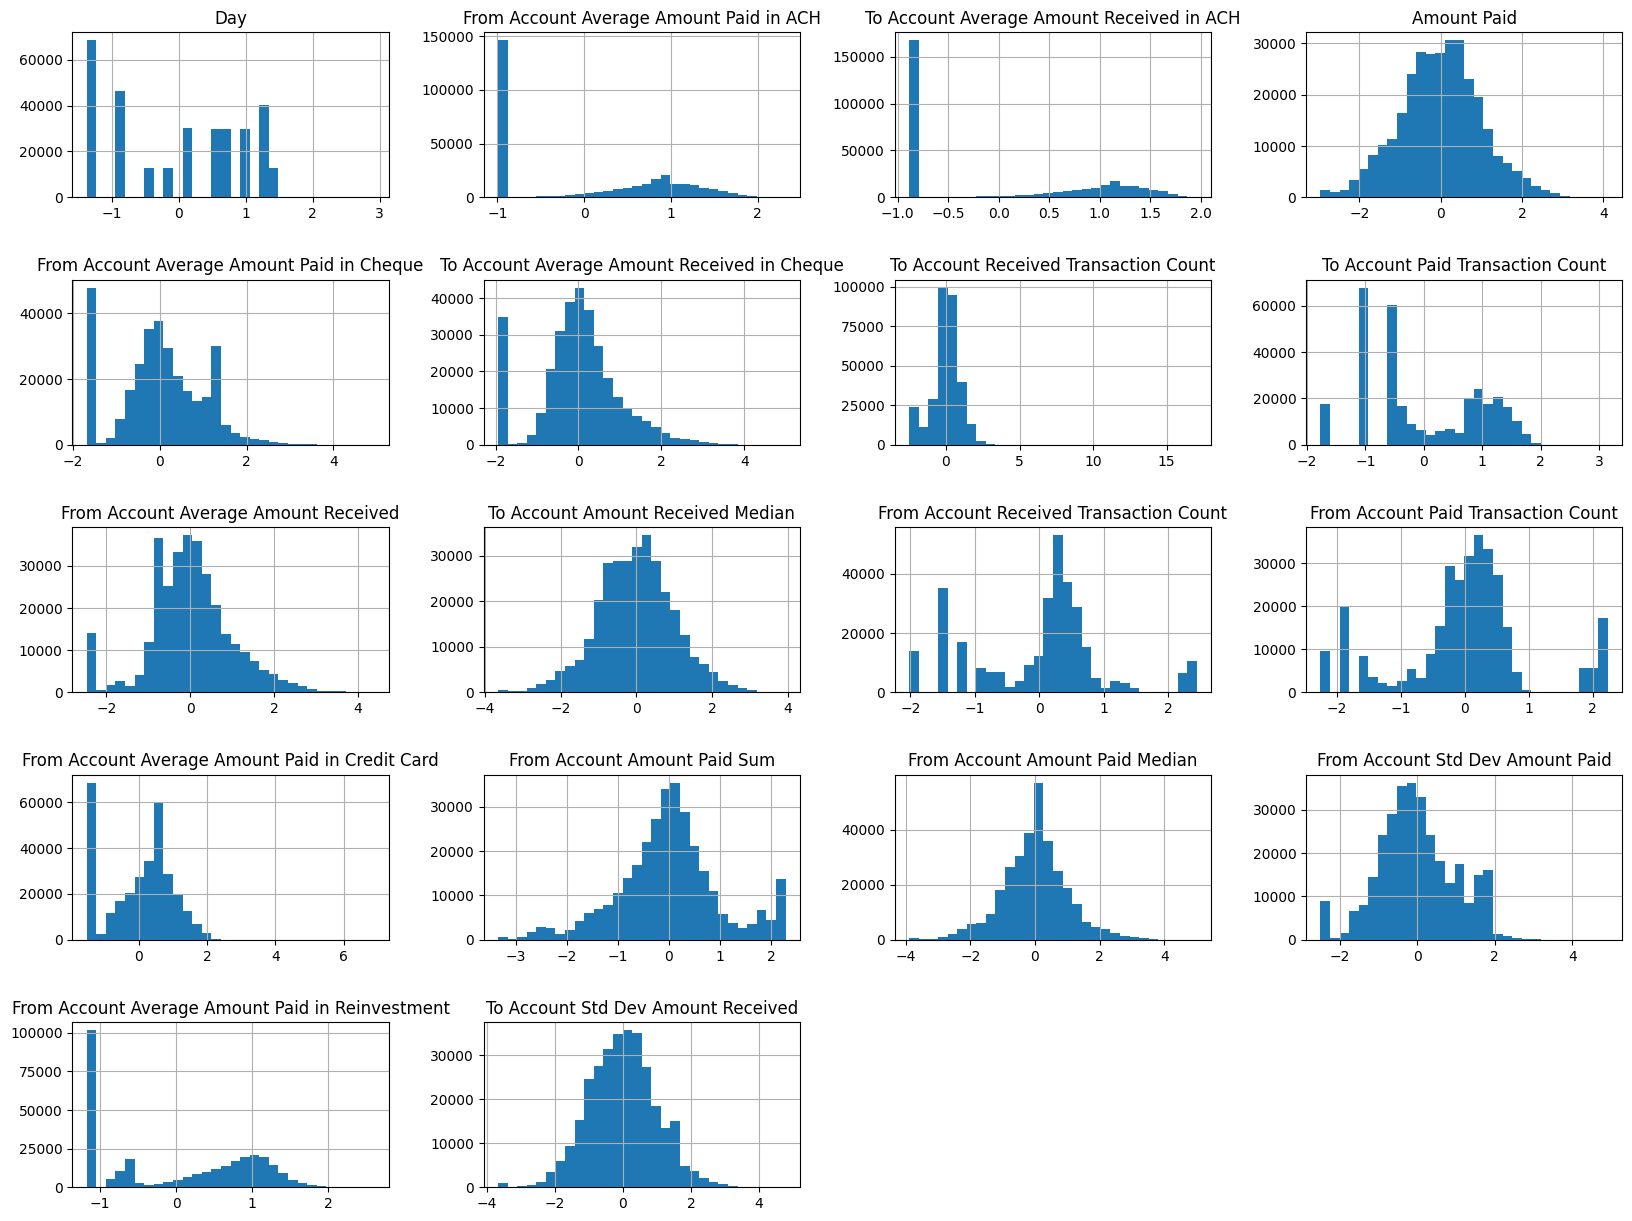

In [14]:
# Create a transformation pipeline, first normalize and then standardize the values
trans_pipe = Pipeline([
    ('power_transform', PowerTransformer(standardize=False)),
    ('scaler', StandardScaler()),
])

# Fit and transform the training data
X_resampled_transformed = trans_pipe.fit_transform(X_resampled)

# Only transform the test data to avoid data leakage
X_test_transformed = trans_pipe.transform(X_test)

# Transform back array of features to data frame
X_resampled_transformed_df = pd.DataFrame(X_resampled_transformed, columns = X_resampled.columns)

# Show histograms of all variables after transformation
X_resampled_transformed_df.hist(bins=30, figsize=(20,15))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Random Classifier (Bernoulli Distribution)

In [15]:
np.random.seed(random_state)

# Generate random predictions based on the Bernoulli distribution
y_random_pred = np.random.choice([0, 1], size=len(y_test), p=[0.999, 0.001])

# Confusion matrix test set
confusion_matrix(y_true=y_test, y_pred=y_random_pred)

array([[1998430,    1969],
       [   2069,       2]], dtype=int64)

### Decision Tree

In [16]:
# Define sets of parameter for randomized search
params_dt = {  
    'max_depth': [5, 10, 20, 30], 
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Define model with remaining parameters
dt = DecisionTreeClassifier(criterion='gini', random_state=random_state)

# Set up a RandomizedSearchCV and fit it to train set
grid_dt = RandomizedSearchCV(estimator=dt, random_state=random_state,
                            param_distributions=params_dt,
                            n_iter=40, cv=5, scoring='f1', n_jobs=-1)

grid_dt.fit(X_resampled_transformed, y_resampled)

# Choose the best estimator
best_dt = grid_dt.best_estimator_ 

In [17]:
# Get best parameter according to tuning
grid_dt.best_params_

{'min_samples_split': 3, 'min_samples_leaf': 9, 'max_depth': 20}

In [18]:
# Predictions on train set
y_train_pred_dt = best_dt.predict(X_resampled_transformed)

# Confusion matrix train set
confusion_matrix(y_true=y_resampled, y_pred=y_train_pred_dt)

array([[310265,    335],
       [  1226,   1880]], dtype=int64)

In [19]:
# Predictions on test set
y_test_pred_dt = best_dt.predict(X_test_transformed)

# Confusion matrix test set
confusion_matrix(y_true=y_test, y_pred=y_test_pred_dt)

array([[1995975,    4424],
       [   1041,    1030]], dtype=int64)

In [20]:
# Classification report test set
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2000399
           1       0.19      0.50      0.27      2071

    accuracy                           1.00   2002470
   macro avg       0.59      0.75      0.64   2002470
weighted avg       1.00      1.00      1.00   2002470



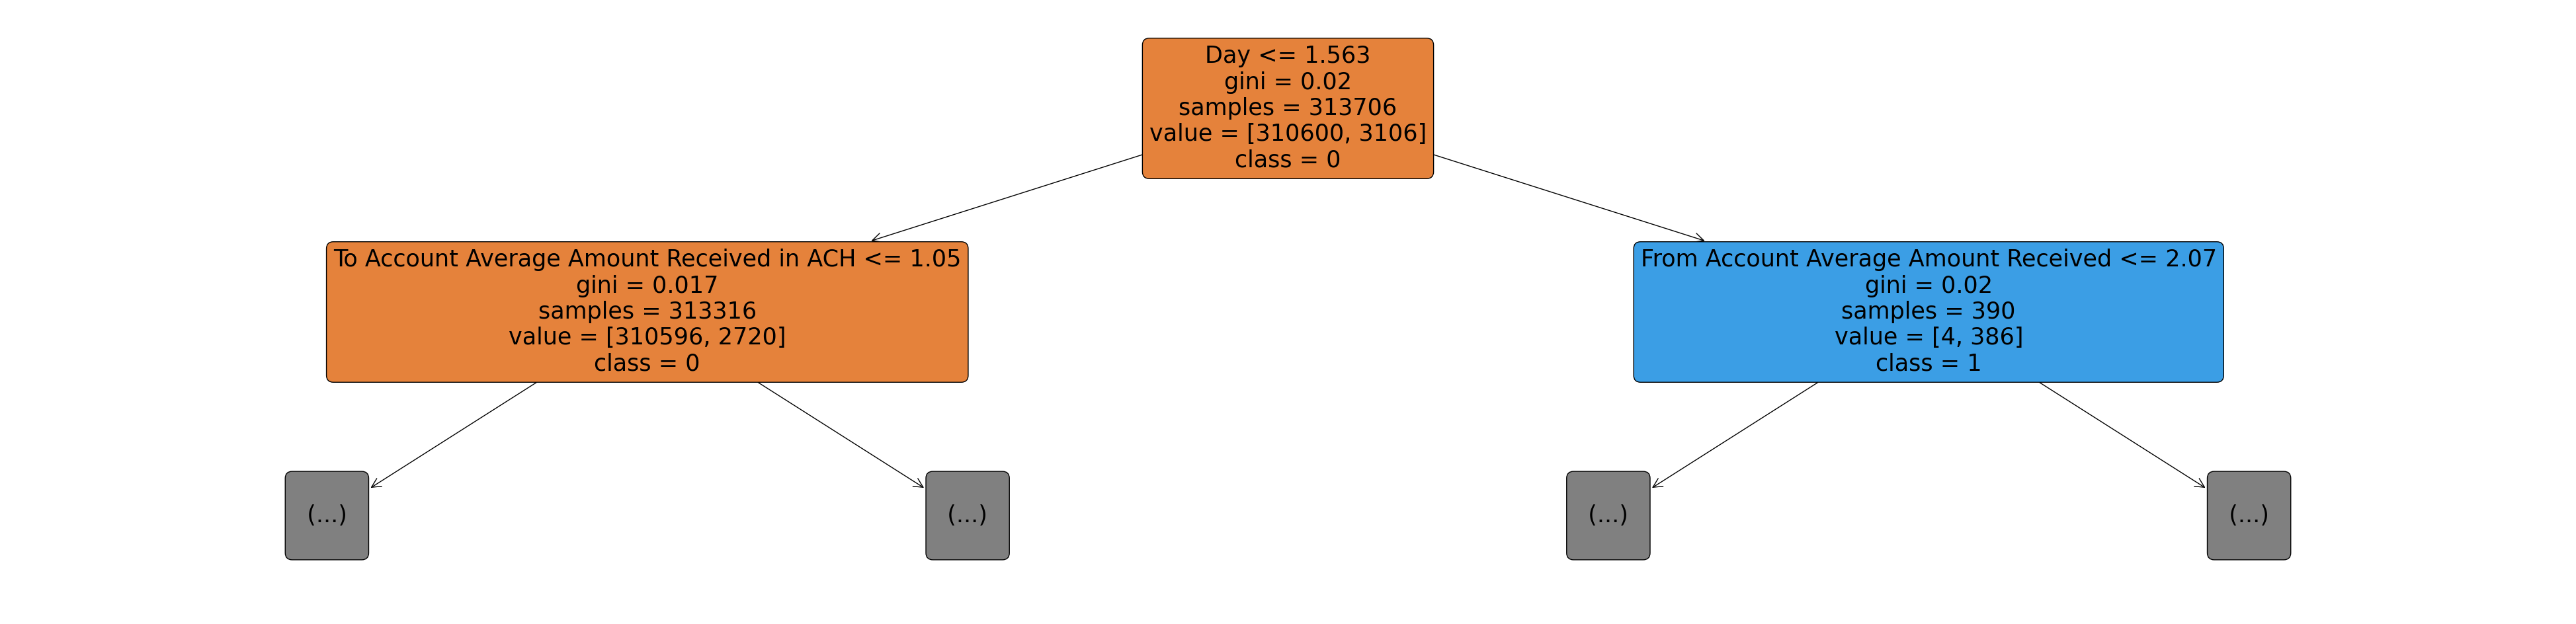

In [21]:
# Plot top of the tree for visualisation
plt.figure(figsize=(50,12))
plot_tree(best_dt, feature_names=X.columns, class_names=['0', '1'], filled=True, rounded=True, max_depth=1)
plt.show()

### Random Forest

In [22]:
# Define sets of parameter for randomized search
params_rf = {
    'n_estimators': [100, 200, 300, 400], 
    'max_features': [3, 5, 7, 9], 
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Define model with remaining parameters
rf = RandomForestClassifier(criterion='gini', bootstrap=True, random_state=random_state)

# Set up a RandomizedSearchCV and fit it to train set
grid_rf = RandomizedSearchCV(estimator=rf, random_state=random_state,
                            param_distributions=params_rf,
                            n_iter=40, cv=5, scoring='f1', n_jobs=-1)

grid_rf.fit(X_resampled_transformed, y_resampled)

# Choose the best estimator
best_rf = grid_rf.best_estimator_ 

In [23]:
# Get best parameter according to tuning
grid_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 7,
 'max_depth': 20}

In [24]:
# Predictions on train set
y_train_pred_rf = best_rf.predict(X_resampled_transformed)

# Confusion matrix train set
confusion_matrix(y_true=y_resampled, y_pred=y_train_pred_rf)

array([[310587,     13],
       [  1009,   2097]], dtype=int64)

In [25]:
# Predictions on test set
y_test_pred_rf = best_rf.predict(X_test_transformed)

# Confusion matrix test set
confusion_matrix(y_true=y_test, y_pred=y_test_pred_rf)

array([[1999385,    1014],
       [   1147,     924]], dtype=int64)

In [26]:
# Classification report test set
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2000399
           1       0.48      0.45      0.46      2071

    accuracy                           1.00   2002470
   macro avg       0.74      0.72      0.73   2002470
weighted avg       1.00      1.00      1.00   2002470



### Support Vector Machine

In [27]:
# Define sets of parameter for randomized search
params_svm = {
    'gamma': ['auto', 'scale', 0.1, 1, 10], # RBF smoothness (the smaller, the closer to linear)
    'C':[0.01, 0.1, 1, 10, 100] # regularization (the smaller, the more regularized)
}

# Define model with remaining parameters
svm = SVC(random_state=random_state, kernel='rbf', probability=True, max_iter=10_000, cache_size=16_000, tol=1)

# Set up a RandomizedSearchCV and fit it to train set
grid_svm = RandomizedSearchCV(estimator=svm, random_state=random_state,
                        param_distributions=params_svm,
                        n_iter=10, cv=5, scoring='f1', n_jobs=-1)

grid_svm.fit(X_resampled_transformed, y_resampled)

# Choose the best estimator
best_svm = grid_svm.best_estimator_ 

In [28]:
# Get best parameter according to tuning
grid_svm.best_params_

{'gamma': 0.1, 'C': 1}

In [29]:
# Predictions on train set
y_train_pred_svm = best_svm.predict(X_resampled_transformed)

# Confusion matrix train set
confusion_matrix(y_true=y_resampled, y_pred=y_train_pred_svm)

array([[310392,    208],
       [  1680,   1426]], dtype=int64)

In [30]:
# Predictions on test set
y_test_pred_svm = best_svm.predict(X_test_transformed)

# Confusion matrix test set
confusion_matrix(y_true=y_test, y_pred=y_test_pred_svm)

array([[1998520,    1879],
       [   1237,     834]], dtype=int64)

In [31]:
# Classification report test set
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2000399
           1       0.31      0.40      0.35      2071

    accuracy                           1.00   2002470
   macro avg       0.65      0.70      0.67   2002470
weighted avg       1.00      1.00      1.00   2002470



### KNN

In [32]:
# Define sets of parameter for randomized search
params_knn = {
    'n_neighbors':[3, 5, 7, 9], 
    'weights':['uniform', 'distance'], 
    'metric':['euclidean', 'manhattan', 'minkowski'] 
}

# Define model with remaining parameters
knn = KNeighborsClassifier()

# Set up a RandomizedSearchCV and fit it to train set
grid_knn = RandomizedSearchCV(estimator=knn, random_state=random_state,
                        param_distributions=params_knn,
                        n_iter=20, cv=5, scoring='f1', n_jobs=-1)

grid_knn.fit(X_resampled_transformed, y_resampled)

# Choose the best estimator
best_knn = grid_knn.best_estimator_ 

In [33]:
# Get best parameter according to tuning
grid_knn.best_params_

{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}

In [34]:
# Predictions on train set
y_train_pred_knn = best_knn.predict(X_resampled_transformed)

# Confusion matrix train set
confusion_matrix(y_true=y_resampled, y_pred=y_train_pred_knn)

array([[310417,    183],
       [  1221,   1885]], dtype=int64)

In [35]:
# Predictions on test set
y_test_pred_knn = best_knn.predict(X_test_transformed)

# Confusion matrix test set
confusion_matrix(y_true=y_test, y_pred=y_test_pred_knn)

array([[1997565,    2834],
       [   1092,     979]], dtype=int64)

In [36]:
# Classification report test set
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2000399
           1       0.26      0.47      0.33      2071

    accuracy                           1.00   2002470
   macro avg       0.63      0.74      0.67   2002470
weighted avg       1.00      1.00      1.00   2002470



### Precision-Recall-Curves

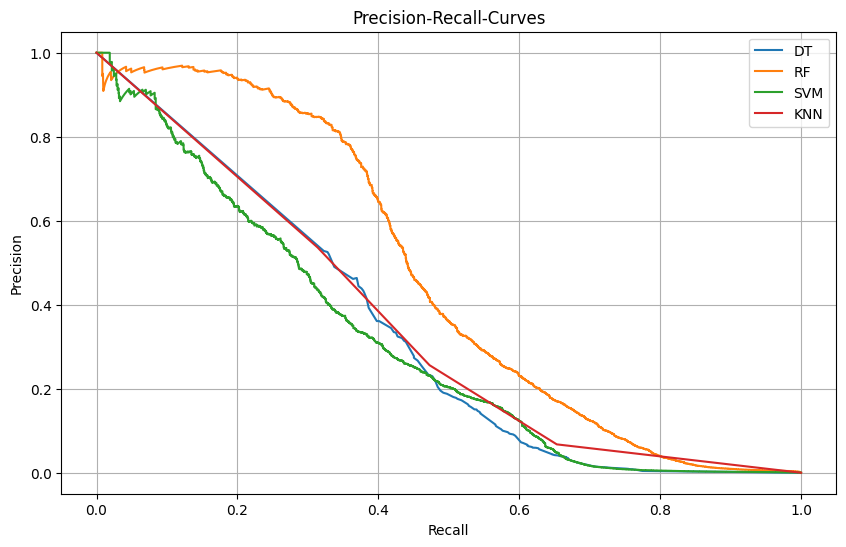

In [37]:
# Compute Precision-Recall-Curve for DT
y_proba_dt = best_dt.predict_proba(X_test_transformed)[:, 1]
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_proba_dt)

# Compute Precision-Recall-Curve for RF
y_proba_rf = best_rf.predict_proba(X_test_transformed)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

# Compute Precision-Recall-Curve for SVM
y_proba_svm = best_svm.predict_proba(X_test_transformed)[:, 1]
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_proba_svm)

# Compute Precision-Recall-Curve for KNN
y_proba_knn = best_knn.predict_proba(X_test_transformed)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)

# Define figure size
plt.figure(figsize=(10, 6))

# Plot precision-recall-curves for all methods
plt.plot(recall_dt, precision_dt, label='DT')
plt.plot(recall_rf, precision_rf, label='RF')
plt.plot(recall_svm, precision_svm, label='SVM')
plt.plot(recall_knn, precision_knn, label='KNN')

# Name titel and labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Curves')

# Define legend for different learner
plt.legend()

# Define grid for clearer visualisation
plt.grid(True)

# Show plot
plt.show()